In [117]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.ndimage import gaussian_filter
from scipy.interpolate import LinearNDInterpolator

In [118]:
def phi_calc(Xi,Xj,N_internal, Xj_neighbours):
    Ni = Xi.shape[0]
    Nj = Xj.shape[0]
    phi_mat = np.zeros((Ni,Nj))
    dphidx_mat = np.zeros((Ni,Nj))
    dphidz_mat = np.zeros((Ni,Nj))
    d2phidx2_mat = np.zeros((Ni,Nj))
    d2phidz2_mat = np.zeros((Ni,Nj))
    d2phidxdz_mat = np.zeros((Ni,Nj))


    #taking the ith point from Xi:
    for i in range(0,Ni):

        x = Xi[i,0]
        z = Xi[i,1]

        #finding the nearest point in the internal points in Xj
        nearest_point = np.argmin((Xj[0:N_internal,0]-x)**2 + (Xj[0:N_internal,1]-z)**2)
        #print(nearest_point)

        #the indices of points used for interpolation is therefore given by the neighbours of the nearest point
        #Xj_neighbours[nearest_point,:]

        #which have a coordinate set:
        X = Xj[Xj_neighbours[nearest_point,:],:]

        #fitting polynomial:
        poly_mat = np.zeros((9,9))

        for j in range(0,9):
            poly_mat[j,0] = 1
            poly_mat[j,1] = X[j,0]
            poly_mat[j,2] = X[j,1]
            poly_mat[j,3] = X[j,0]**2
            poly_mat[j,4] = X[j,1]**2
            poly_mat[j,5] = X[j,0]*X[j,1]
            poly_mat[j,6] = X[j,0]**2*X[j,1]
            poly_mat[j,7] = X[j,1]**2*X[j,0]
            poly_mat[j,8] = X[j,0]**2*X[j,1]**2


        #matrix of polynomial coefficients
        #print(i)
        
        coef_mat = np.linalg.inv(poly_mat)
        #print(np.linalg.cond(coef_mat))


        #calculating the value of the 9 polynomials at point (x,z)
        polynomial = np.zeros((1,9))
        for j in range(0,9):
            polynomial[:,j] = coef_mat[0,j] + coef_mat[1,j]*x + coef_mat[2,j]*z + coef_mat[3,j]*x*x + coef_mat[4,j]*z*z 
            polynomial[:,j] += coef_mat[5,j]*x*z + coef_mat[6,j]*x*x*z + coef_mat[7,j]*x*z*z + coef_mat[8,j]*x*x*z*z

        #calculating value of derivatives at point (x,z)
        dpdx = np.zeros((1,9))
        for j in range(0,9):
            dpdx[:,j] = coef_mat[1,j] + 2*coef_mat[3,j]*x + coef_mat[5,j]*z + coef_mat[6,j]*x*z*2 + coef_mat[7,j]*z*z + coef_mat[8,j]*x*z*z*2

        dpdz = np.zeros((1,9))
        for j in range(0,9):
            dpdz[:,j] = coef_mat[2,j] + 2*coef_mat[4,j]*z + coef_mat[5,j]*x + coef_mat[6,j]*x*x + coef_mat[7,j]*x*z*2 + coef_mat[8,j]*x*x*z*2

        d2pdx2 = np.zeros((1,9))
        for j in range(0,9):
            d2pdx2[:,j] = 2*coef_mat[3,j] + coef_mat[6,j]*2*z + coef_mat[8,j]*2*z*z

        d2pdz2 = np.zeros((1,9))
        for j in range(0,9):
            d2pdz2[:,j] = 2*coef_mat[4,j] + coef_mat[7,j]*2*x + coef_mat[8,j]*x*x*2

        d2pdxdz = np.zeros((1,9))
        for j in range(0,9):
            d2pdxdz[:,j] = coef_mat[5,j] + coef_mat[6,j]*2*x + coef_mat[7,j]*2*z + coef_mat[8,j]*4*x*z


        #inserting vector of polynomial values back into the phi matrix:
        phi_mat[i,Xj_neighbours[nearest_point,:]] = polynomial
        dphidx_mat[i,Xj_neighbours[nearest_point,:]] = dpdx
        dphidz_mat[i,Xj_neighbours[nearest_point,:]] = dpdz
        d2phidz2_mat[i,Xj_neighbours[nearest_point,:]] = d2pdz2 
        d2phidx2_mat[i,Xj_neighbours[nearest_point,:]] = d2pdx2 
        d2phidxdz_mat[i,Xj_neighbours[nearest_point,:]] = d2pdxdz 


    return phi_mat, dphidx_mat, dphidz_mat, d2phidx2_mat,d2phidz2_mat,d2phidxdz_mat

In [119]:
#numerical parameters
pi = 3.14159
dx = 0.1
g = 1.0
tilt_angle = pi/4

In [120]:
#building grid:
dx = 0.05
#xx,zz = np.meshgrid(np.arange(0,1+dx,dx),np.arange(0,1+dx,dx))
xx,zz = np.meshgrid(np.arange(0.05,0.95+dx,dx),np.arange(0.05,0.95+dx,dx))
nx = xx.shape[0]
nz = xx.shape[1]
xxi = xx[1:-1,1:-1]
zzi = zz[1:-1,1:-1]
nxi = xxi.shape[0]
nzi = zzi.shape[1]
Xinternal = np.stack((xxi.flatten(),zzi.flatten()),axis=1)
Xbc1 = np.stack((xx[1:-1,0].flatten(),zz[1:-1,0].flatten()),axis=1)
Xbc2 = np.stack((xx[1:-1,-1].flatten(),zz[1:-1,-1].flatten()),axis=1)
Xbc3 = np.stack((xx[0,:].flatten(),zz[0,:].flatten()),axis=1)
Xbc4 = np.stack((xx[-1,:].flatten(),zz[-1,:].flatten()),axis=1)
nbc0 = Xinternal.shape[0]
N_internal = nbc0 + 0
nbc1 = Xbc1.shape[0] + nbc0
nbc2 = Xbc2.shape[0] + nbc1
nbc3 = Xbc3.shape[0] + nbc2 
ncb4 = Xbc4.shape[0] + nbc3
X = np.concatenate((Xinternal,Xbc1,Xbc2,Xbc3,Xbc4),axis=0)
N = X.shape[0]

#finding neighbouring points:

#finding nnearest neighbours of each point in Xj
r2 = (X[:,0:1]-X[:,0:1].transpose())**2 + (X[:,1:2]-X[:,1:2].transpose())**2

X_neighbours = np.zeros((X.shape[0],9),dtype = int)

X_neighbours = np.zeros((X.shape[0],9),dtype = int)
for i in range(0,X.shape[0]):
    X_neighbours[i,:] = (np.argpartition(r2[:,i],9)[0:9])

phi_testing = False

In [121]:
#solving:

#Nusselt Solution:

mu_true = 0.01

#data = np.loadtxt('cavityNewtonian_Re0_1_0.csv',delimiter = ',')
data = np.loadtxt('cavityNonNewtonian_n0_5_k0_01_0.csv',delimiter = ',')
data = np.loadtxt('cavityNonNewtonian_n2_k0_01_0.csv',delimiter = ',')

u_data = data[:,1] 
v_data = data[:,2]
p_data = data[:,0]
Xu = data[:,4]
Zu = data[:,5]



u_interp = LinearNDInterpolator(list(zip(Xu,Zu)), u_data)
v_interp = LinearNDInterpolator(list(zip(Xu,Zu)), v_data)
p_interp = LinearNDInterpolator(list(zip(Xu,Zu)), p_data)

u_test = u_interp(X[:,0:1],X[:,1:2])
v_test = v_interp(X[:,0:1],X[:,1:2])
p_test = p_interp(X[:,0:1],X[:,1:2])

#Nusselt:

mu_true = 0.1

#u_test = g*np.sin(tilt_angle)*(X[:,1:2]-0.5*X[:,1:2]**2)/mu_true
#v_test = u_test*0

#applying noise:

epsilon = 0.0

u_test += epsilon*np.random.randn(u_test.shape[0],u_test.shape[1])

#finding relevent derivative fields:
phi_mat, dphidx_mat, dphidz_mat, d2phidx2_mat,d2phidz2_mat,d2phidxdz_mat = phi_calc(X,X,N_internal, X_neighbours)


phi_u = phi_mat + 0
nabla2_phi_u = d2phidx2_mat + d2phidz2_mat
dphi_u_dx = dphidx_mat + 0
dphi_u_dz = dphidz_mat + 0
d2phi_u_dx2 = d2phidx2_mat + 0
d2phi_u_dz2 = d2phidz2_mat + 0
d2phi_u_dxdz = d2phidxdz_mat + 0


u_j = np.linalg.solve(phi_u,u_test)
v_j = np.linalg.solve(phi_u,v_test)

u = np.diag(u_test.flatten())
v = np.diag(v_test.flatten())
nabla2_u = np.diag(np.matmul(nabla2_phi_u,u_j).flatten())
nabla2_v = np.diag(np.matmul(nabla2_phi_u,v_j).flatten())
dudx = np.diag(np.matmul(dphi_u_dx,u_j).flatten())
dudz = np.diag(np.matmul(dphi_u_dz,u_j).flatten())
dvdx = np.diag(np.matmul(dphi_u_dx,v_j).flatten())
dvdz = np.diag(np.matmul(dphi_u_dz,v_j).flatten())
d2udx2 = np.diag(np.matmul(d2phi_u_dx2,u_j).flatten())
d2udz2 = np.diag(np.matmul(d2phi_u_dz2,u_j).flatten())
d2udxdz = np.diag(np.matmul(d2phi_u_dxdz,u_j).flatten())
d2vdx2 = np.diag(np.matmul(d2phi_u_dx2,v_j).flatten())
d2vdz2 = np.diag(np.matmul(d2phi_u_dz2,v_j).flatten())
d2vdxdz = np.diag(np.matmul(d2phi_u_dxdz,v_j).flatten())

In [122]:
gov_mat = np.zeros((2*N,2*N))

#horizontal momentum:

#viscosity terms
gov_mat[0:N,0:N] =  2*np.matmul(dudx,dphi_u_dx) + 2*np.matmul(d2udx2,phi_u) + np.matmul(dudz + dvdx,dphi_u_dz) + np.matmul(d2udz2+d2vdxdz,phi_u)

#pressure term

gov_mat[0:N,N:2*N] = -dphi_u_dx

#vertical momentum:

gov_mat[N:2*N,0:N] =  2*np.matmul(dvdz,dphi_u_dz) + 2*np.matmul(d2vdz2,phi_u) + np.matmul(dudz + dvdx,dphi_u_dx) + np.matmul(d2udxdz+d2vdx2,phi_u)

#pressure term

gov_mat[N:2*N,N:2*N] = -dphi_u_dz 


#boundary conditions
#at the surface we require that mu = 0 and p = 0

#gov_mat[nbc3:N,:] = 0
#gov_mat[nbc3+N:2*N,:] = 0

#viscosity bc:
#gov_mat[nbc3:N,0:N] = phi_u[nbc3:N,0:N]

#pressure bc:
#gov_mat[nbc3+N:2*N,N:2*N] = phi_u[nbc3:N,0:N]

In [123]:
#inhomogeneous condition

bc_vector = np.zeros((2*N,1))
bc_vector[0:N,0] = np.diag(u)*np.diag(dudx) + np.diag(v)*np.diag(dudz) #- g*np.sin(tilt_angle)
bc_vector[N:2*N,0] = np.diag(u)*np.diag(dvdx) + np.diag(v)*np.diag(dvdz) #+ g*np.cos(tilt_angle)
#bc_vector[nbc3:N,0] = 0.01
#bc_vector[nbc3+N:2*N,0] = 0


In [124]:
viscosity_smoothness_parameter = 10
pressure_smoothness_parameter = 1000
LS_mat = np.zeros((5*N,2*N))
LS_vect = np.zeros((5*N,1))
LS_mat[0:2*N,0:2*N] = gov_mat
LS_mat[2*N:3*N,0:N] = viscosity_smoothness_parameter*dphi_u_dz*dx
LS_mat[3*N:4*N,0:N] = viscosity_smoothness_parameter*dphi_u_dx*dx
LS_mat[4*N:5*N,N:2*N] = pressure_smoothness_parameter*phi_u


LS_vect[0:2*N,:] = bc_vector
LS_vect[4*N:5*N,:] = pressure_smoothness_parameter*p_test
LS_solution = np.linalg.lstsq(LS_mat,LS_vect)

<ipython-input-124-423c9e138c8d>:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  LS_solution = np.linalg.lstsq(LS_mat,LS_vect)


Text(0.5, 0, 'shear')

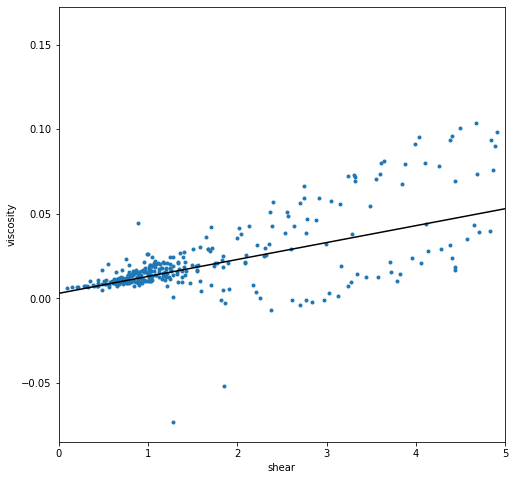

In [129]:
plt.figure(figsize=(8,8))
gamma = np.sqrt(np.diag(dudx)**2 + np.diag(dudz)**2 + np.diag(dvdx)**2 + np.diag(dvdz)**2)
plt.plot(gamma,LS_solution[0][0:N,:],'.')
gamma_plot = np.arange(0.1,10,0.1)
#plt.plot(gamma_plot-0.2,0.01*gamma_plot**(-0.5),'k')
plt.plot(gamma_plot-0.3,gamma_plot*0.01,'k')
plt.xlim([0,5])
plt.ylabel('viscosity')
plt.xlabel('shear')

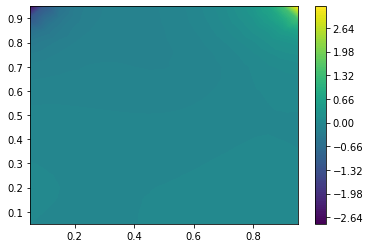

In [126]:
plt.tricontourf(X[:,0],X[:,1],LS_solution[0][N:2*N,0],levels=100)
#plt.tricontourf(Xr[:,0],Xr[:,1],p_hydrostatic[:,0],levels=100)
plt.colorbar()

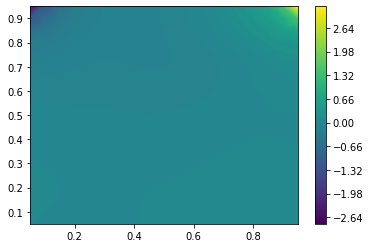

In [127]:
plt.tricontourf(X[:,0],X[:,1],p_test[:,0],levels=100)
#plt.tricontourf(Xr[:,0],Xr[:,1],p_hydrostatic[:,0],levels=100)
plt.colorbar()